<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/NegEx_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stanza
!pip install spacy_stanza
!pip install negspacy
!pip install negex
!pip install negfinder
!pip install negexpander
!pip install spacy-pipeline-negex



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 12.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for negspacy: filename=negspacy-1.0.4-py3-none-any.whl size=12535 sha256=98ea218655975233cdeb28f0319b56fac5c6e9179e597c14deb8835f59b69273
  Stored in directory: /root/.cache/pip/wheels/15/31/f0/3a217aaedf320e4df653347cd6538f3648263b864c8e140853
Successfully built negspacy
ERROR: Could not find a version that satisfies the requirement negfinder (from versions: none)
ERROR: No matching distribution found for negfinder
ERROR: Could not find a version that satisfies the requirement negexpander (from versions: none)
ERROR: No matching distribution found for negexpander
ERROR: Could not find a version that satisfies the requirement spacy-pipe

In [2]:
import spacy # to build a nlp pipeline
import stanza # for named entity recognition
# this package wraps Stanza around Spacy, so that we can use Stanza in a spaCy pipeline.
import spacy_stanza
from negspacy.negation import Negex
from negspacy.termsets import termset # to customize negation terms
import pandas as pd
from tqdm.auto import tqdm
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

## **RBM #1 : NegEx**

In [49]:
# download and initialize a mimic pipeline with an i2b2 NER model
# stanza.download('en', package='mimic', processors={'ner': 'i2b2'})
nlp = spacy_stanza.load_pipeline('en', package='mimic', processors={'ner': 'i2b2'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
# nlp.add_pipe("negex", config={"ent_types":["PROBLEM","TEST",'TREATMENT']})

ValueError: ignored

In [ ]:
# nlp = spacy.load("en_core_sci_sm")
# import spacy
# from spacy.pipeline.negex import NegexComponent

# nlp = spacy.load("en_core_sci_sm")
# negex = NegexComponent(config={"chunk_prefix": ["no", "none", "not", "nor", "without"]})
# nlp.add_pipe(negex)


In [50]:
import spacy
import pandas as pd
from tqdm import tqdm

# Load spaCy model with the NegEx component
# nlp = spacy.load("en_core_sci_sm")
# nlp.add_pipe("negex", config={"chunk_prefix": ["no", "none", "not", "nor", "without","lack"]})

# Initialize an empty list to store predictions
predictions = []

# Iterate through the text in your DataFrame
for text in tqdm(df["selected_sentence"]):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether the sentence contains negations
    contains_negation = False

    # Iterate through sentences and check for negations
    for sent in doc.sents:
        for ent in sent.ents:
            if ent._.negex:
                contains_negation = True
                break

    # Determine the final classification (0 for negation, 1 for non-negation)
    prediction = 0 if contains_negation else 1
    predictions.append(prediction)

# Add the predictions as a new column in the dataframe
df['predicted'] = predictions


  0%|          | 0/694 [00:00<?, ?it/s]


ValueError: ignored

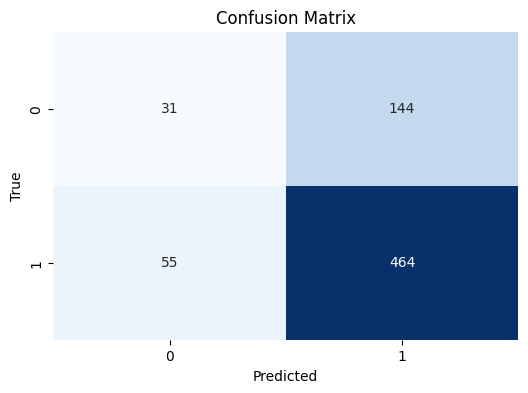

Accuracy: 0.71
Precision: 0.76
Recall: 0.89
F1 Score: 0.82


In [ ]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [ ]:
df[["label","selected_sentence"]]

,label,selected_sentence
0,yes,The Statfjord reservoir is overpressured (emw ...
1,yes,‘ The Brent reservoir is overpressured (emw 1...
2,yes,"» Finally, the core measurements have not been..."
3,yes,Also if the pressure in the Lower Unit should ...
4,yes,As regards the two pressures obtained in the w...
...,...,...
689,yes,"wide , ft , dull , yelwh t/t 20 % patchy grny/..."
690,yes,however no toc data avocet 1a and lorikeer 1 o...
691,yes,however no toc data avocet 1a and lorikeer 1 o...
692,yes,lower levels of these unknown compounds is not...


## **RBM #2 : Filter with negation terms**

In [ ]:
import spacy
import pandas as pd

# Load the SpaCy model
nlp = spacy.load('en_core_web_sm')

# Define the negation terms
negation_terms = ["no", "none", "not", "nor", "without"]

# Your DataFrame (replace this with your actual DataFrame)
# df = pd.read_csv("your_dataset.csv")

# Define a function for negation detection
def detect_negation(text):
    # Process the text with SpaCy
    doc = nlp(text)

    # Initialize a variable to track whether negation is detected
    negation_detected = False

    # Iterate through the tokens and check for negation terms
    for token in doc:
        if token.text.lower() in negation_terms:
            negation_detected = True
            break

    return negation_detected

# Apply the negation detection function to each text in the DataFrame
df["predicted"] = df["doc_text_original"].apply(detect_negation)

# Map the negation detection result to 0 (negation) or 1 (non-negation)
df["predicted"] = df["predicted"].astype(int)



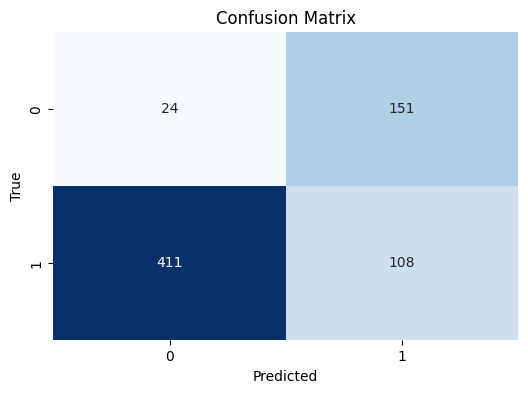

Accuracy: 0.19
Precision: 0.42
Recall: 0.21
F1 Score: 0.28


In [ ]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## **RBM #3 : Deterministic Option**

In [17]:
import pandas as pd
import re
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

# Load your CSV dataset
df = pd.read_csv("true_positive_experimentation.csv")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Unit Test Text**

In [63]:
def unit_test(input_text):

  # Define the topics as flexible terms (subwords or whole words)
  topics = ["overpressure","overpressuring", "sand production", "oil show"]

  # Define the negation terms pattern with case-insensitivity
  negation_terms = r'(?i)(?:(?<=\s)|^)(no|none|not|nor|without)(?=\s|$)'

  # Initialize a WordNet lemmatizer
  lemmatizer = WordNetLemmatizer()

  # Define a custom lemmatization rule to replace "ized" with "e"
  def custom_lemmatizer(word):
      if word.endswith("ized"):
          return re.sub(r'ized$', 'e', word)
      else:
          return lemmatizer.lemmatize(word)

  # Initialize a list to store selected sentences
  selected_sentences_1 = []

  # Convert the text to lowercase
  text = input_text.lower()  # Convert to lowercase

  # Tokenize the text into sentences using NLTK's sent_tokenize
  sentences = sent_tokenize(text)

  # Initialize a flag to check for both topic terms and negation terms
  both_detected = False


  if len(sentences) == 1:
      # If there is only one sentence, append the entire text

      selected_sentences_1.append(text)
  else:
      for sentence in sentences:


        # Initialize a flag to check if any topic term is found in the sentence
        topic_found = False

        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Lemmatize each word using the custom lemmatizer
        lemmatized_words = [custom_lemmatizer(word) for word in words]

        # Join the lemmatized words back into a sentence
        lemmatized_sentence = ' '.join(lemmatized_words)

        # Check if the sentence contains any of the specified topics (partial matches)
        for topic in topics:
            if topic in lemmatized_sentence.lower():  # Convert to lowercase for matching
                topic_found = True
                break

        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, lemmatized_sentence.lower()):
            negation_detected = True
        else:
            negation_detected = False

        # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
        if (topic_found is True) and (negation_detected is True):
            selected_sentences_1.append(lemmatized_sentence)
            both_detected = True


        elif (topic_found is True) and (negation_detected is False):
            selected_sentences_1.append(lemmatized_sentence)
            both_detected = True



      # If no suitable sentence is found, set 'None' as a placeholder
      if not both_detected:
          selected_sentences_1.append(None)

  # Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence_1
  # selected_sentence = selected_sentences_1[0]

  neg = ["no", "not", "lack", "nor" , "none" , "without", "rather than"]

  if len(selected_sentences_1) != 1:
    for text in selected_sentences_1:
      for items in neg:
        if items in text:
          selected_sentence = text

  else:
    selected_sentence = selected_sentences_1
    selected_sentence = selected_sentence[0]



  if selected_sentence is not None:
      # Check if the lemmatized sentence contains negation terms
      if re.search(negation_terms, selected_sentence.lower()):
          prediction = 0  # Negation terms found, set the prediction to 0
      else:
          prediction = 1  # No negation terms found, set the prediction to 1
  else:
      prediction = 0  # Handle the case where selected_sentence is None

  # Print the selected sentence and prediction
  print("Selected Sentence:", selected_sentence)
  print("Prediction:", prediction)


In [64]:
# Sample text
input_text = "	This was the major quantitative method used whilst drilling. It is a pore poreeure - drilling rate model which attempts to normalize the drilling rate for changes in weight on bit, rotary speed, hole size and mud weight. It is best suited to a shale - sandstone sequence where normal com- paction trends can be established, and where overpressuring originates from a lack of or hindrance to normal compaction. The corrected D Exponent plot is adversely affected by large differential pressures at the bit (in excess of 500 psi); this suppression is such that little response may occur from a large change in differential pressure. This factor is of particular interest on this well as over- balance during much of the overpressured section was in excess of 1,000 psi. Also of importance is the fact that the D Exponent is best suited to sequences cof pure shales and claystone which were not common in this well. Never- theless the pore pressure of the Brent Sand was accurately calculated using D Exponent and Eatons formula: '"
unit_test(input_text)

Selected Sentence: it is best suited to a shale - sandstone sequence where normal com- paction trend can be established , and where overpressuring originates from a lack of or hindrance to normal compaction .
Prediction: 1


## **Dataframe test**

In [88]:
import re
import nltk
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [96]:
from tkinter.constants import NONE
# Define the topics as flexible terms (subwords or whole words)
topics = ["overpressure","overpressuring", "sand production", "oil show"]

# Define the negation terms pattern with case-insensitivity
negation_terms = r'(?i)(?:(?<=\s)|^)(no|none|not|nor|without|rather)(?=\s|$)'

# Initialize a WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a custom lemmatization rule to replace "ized" with "e"
def custom_lemmatizer(word):
    if word.endswith("ized"):
        return re.sub(r'ized$', 'e', word)
    elif word.endswith("ing"):
        return re.sub(r'ing$', 'e', word)
    else:
        return lemmatizer.lemmatize(word)

# Initialize a list to store selected sentences
selected_sentences = []

# Initialize a flag to check for both topic terms and negation terms
both_detected = False

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    text = row['doc_text_original'].lower()  # Convert to lowercase

    # Tokenize the text into sentences using NLTK's sent_tokenize
    sentences = sent_tokenize(text)

    # Initialize flags to check for both topic terms and negation terms
    topic_found = False
    negation_detected = False

    for sentence in sentences:
        # Tokenize the sentence into words
        words = word_tokenize(sentence)

        # Lemmatize each word using the custom lemmatizer
        lemmatized_words = [custom_lemmatizer(word) for word in words]

        # Join the lemmatized words back into a sentence
        lemmatized_sentence = ' '.join(lemmatized_words)

        # Check if the sentence contains any of the specified topics (partial matches)
        for topic in topics:
            if topic in lemmatized_sentence.lower():  # Convert to lowercase for matching
                topic_found = True
                break

        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, lemmatized_sentence.lower()):
            negation_detected = True
        else:
            negation_detected = False

        # If a topic term is found and either no negation terms are found or negation_detected is False, append the sentence
        if (topic_found is True) and (negation_detected is True):
            selected_sentences.append(lemmatized_sentence)
            both_detected = True
            break

        elif (topic_found is True) and (negation_detected is False):
            selected_sentences.append(lemmatized_sentence)
            both_detected = True
            break


    # If no sentence with both topic and negation terms is found, append the first sentence without a negation term
    if not both_detected or topic_found is False:
        selected_sentences.append(None)




print(len(selected_sentences))


694


In [90]:
# Add the selected_sentences as a new column named 'selected_sentence'
df['selected_sentence'] = selected_sentences

# Determine the prediction (0 or 1) based on the presence of negation terms in selected_sentence
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Check if the lemmatized sentence contains negation terms
        if re.search(negation_terms, selected_sentence.lower()):
            prediction = 0  # Negation terms found, set the prediction to 0
        else:
            prediction = 1  # No negation terms found, set the prediction to 1
    else:
        prediction = 0  # Handle the case where selected_sentence is None

    df.at[index, 'predicted'] = prediction

# Print the DataFrame with the 'label' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted']]

ValueError: ignored

**Evaluating Performance with spaCy Negex package**

In [54]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [55]:
# Import the necessary library for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Initialize a list to store predictions (0 for negation, 1 for non-negation)
predictions_negex = []

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    selected_sentence = row['selected_sentence']

    if selected_sentence is not None:
        # Use SentimentIntensityAnalyzer to get sentiment polarity score
        sentiment_score = sia.polarity_scores(selected_sentence)

        # Determine the prediction based on the sentiment score
        if sentiment_score['compound'] < 0:
            prediction_negex = 0  # Negative sentiment, set prediction to 0 (negation)
        else:
            prediction_negex = 1  # Positive or neutral sentiment, set prediction to 1 (non-negation)
    else:
        prediction_negex = 0  # Handle the case where selected_sentence is None

    predictions_negex.append(prediction_negex)

# Add the predictions_negex as a new column named 'prediction_negex'
df['prediction_negex'] = predictions_negex

# Print the DataFrame with the 'label' column and the new 'prediction_negex' column
df[['doc_text_original', 'selected_sentence', 'label_code', 'predicted', 'prediction_negex']]


,doc_text_original,selected_sentence,label_code,predicted,prediction_negex
0,The Statfjord reservoir is overpressured (emw ...,the statfjord reservoir is overpressured (emw ...,1,1.0,1
1,‘ The Brent reservoir is overpressured (emw 1...,‘ the brent reservoir is overpressured (emw 1...,1,1.0,1
2,"» Finally, the core measurements have not been...",this would somewhat reduce the porosity value ...,1,1.0,1
3,Also if the pressure in the Lower Unit should ...,also if the pressure in the lower unit should ...,1,1.0,0
4,As regards the two pressures obtained in the w...,as regards the two pressures obtained in the w...,1,1.0,0
...,...,...,...,...,...
689,21 21A 22 22A 23 23A 24 24A 25 25A 26 26A 27 2...,"wide , ft , dull , yelwh t/t 20 % patchy grny/...",1,0.0,0
690,"""used to calculate the geochemical Altbough th...","however , these two the % sc2 % nor sterane ma...",1,0.0,1
691,"""used to calculate the geochemical Altbough th...","however , these two the % sc2 % nor sterane ma...",1,0.0,1
692,lower levels of these unknown compounds is not...,result suggest that the sample represents an o...,1,1.0,1


In [56]:
# Calculate the number of empty cells in the 'selected_sentence_1' column
empty_cells_count = df['selected_sentence'].isna().sum()

print(f"Number of empty cells in 'selected_sentences': {empty_cells_count}")


Number of empty cells in 'selected_sentences': 0


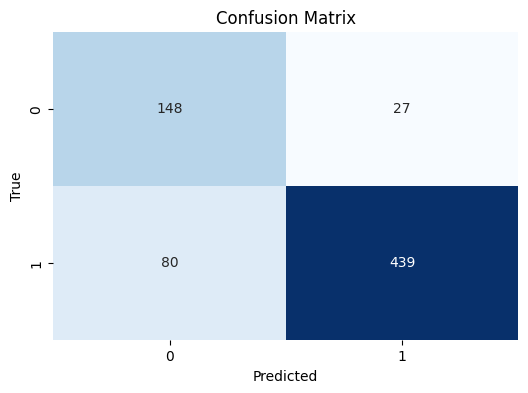

Accuracy: 0.85
Precision: 0.94
Recall: 0.85
F1 Score: 0.89


In [29]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['predicted']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


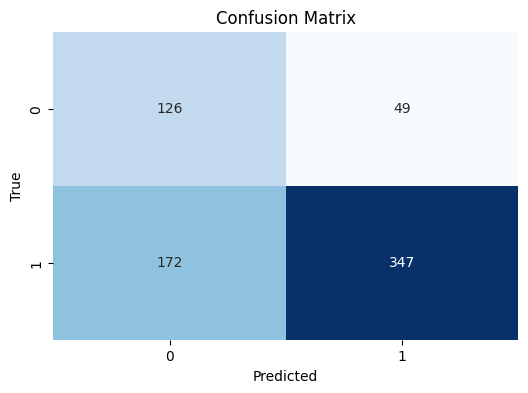

Accuracy: 0.68
Precision: 0.88
Recall: 0.67
F1 Score: 0.76


In [57]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = df['label_code']
y_pred = df['prediction_negex']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


In [87]:
# Save the updated dataframe to a new CSV file
df.to_csv("your_updated_dataset.csv", index=False)